In [23]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import re
import pandas as pd
import tarfile
import P4J
from astropy.table import Table
from astropy.stats import sigma_clip
from metric_tools import *
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, Matern, ConstantKernel as C
import FATS
from gatspy.periodic import LombScargle
from multiprocessing import Pool

%matplotlib inline
sns.set(style="white", color_codes=True, context="notebook", font_scale=1.4)

import warnings
warnings.filterwarnings('ignore')

mainpath = '/Users/jorgetil/Astro/HITS'

In [22]:
global path
global empirical

path = '%s/tables/Blind15A_kronPhot_only.csv' % (mainpath)
empirical = pd.read_csv(path)

In [25]:
def GP_fit(time, mag, err, x_pred=None, plot=True):

    kernel = C(constant_value=1., constant_value_bounds=(.1,.5)) * \
             RBF(length_scale=.3, length_scale_bounds=(0.2, .5))
    #kernel = C(constant_value=1., constant_value_bounds=(0.1,10.)) * \
    #         Matern(length_scale=4., length_scale_bounds=(.1,10.))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=(err)**2, optimizer='fmin_l_bfgs_b',
                                  n_restarts_optimizer=10, normalize_y=True)
    gp.fit(time[:,None], mag)
    x_test=np.linspace(np.min(time),np.max(time),1000)
    y_pred, sigma = gp.predict(x_test[:,None], return_std=True)
    
    mag_pred = gp.predict(x_pred[:,None], return_std=False)
    
    if plot:
        plt.figure(figsize=(9,4))
        plt.errorbar(time, mag, yerr=err, fmt='k.', ms=7, lw=1,alpha=1)
        plt.plot(x_test, y_pred, 'r-', lw= 1)
        plt.fill(np.concatenate([x_test, x_test[::-1]]),
                 np.concatenate([y_pred - 1.9600 * sigma,
                                (y_pred + 1.9600 * sigma)[::-1]]),
                 alpha=.5, fc='b', ec='None')
        plt.plot(x_pred, mag_pred, 'b.')
        plt.gca().invert_yaxis()
        plt.show()
        
    return mag_pred


def GP_fit_periodic(time, mag, err, T, T_1='same', x_pred=None, plot=True):
    if T_1 == 'same':
        T_1 = T
    phase = np.mod(time, T) / T
    sort_idx = np.argsort(phase)
    PHASE = phase[sort_idx]
    MAG = mag[sort_idx]
    ERR = err[sort_idx]
    k=1
    while k < 2:
        MAG = np.concatenate([MAG,MAG])
        PHASE = np.concatenate([PHASE,PHASE+k])
        ERR = np.concatenate([ERR,ERR])
        k += 1
    #PHASE *= T
    kernel = C(constant_value=1., constant_value_bounds=(.1,.5)) * \
             RBF(length_scale=.3, length_scale_bounds=(0.2, .5))
    #kernel = C(constant_value=1., constant_value_bounds=(0.1,10.)) * \
    #         Matern(length_scale=4., length_scale_bounds=(.1,10.))
    gp = GaussianProcessRegressor(kernel=kernel, alpha=(ERR)**2, optimizer='fmin_l_bfgs_b',
                                  n_restarts_optimizer=10, normalize_y=True)
    gp.fit(PHASE[:,None], MAG)
    x_test=np.linspace(0,2,1000)
    y_pred, sigma = gp.predict(x_test[:,None], return_std=True)
    
    phase_pred = np.mod(x_pred, T_1) / T_1
    mag_pred = gp.predict(phase_pred[:,None], return_std=False)
    
    if plot:
        plt.figure(figsize=(9,4))
        plt.errorbar(PHASE, MAG, yerr=ERR, fmt='k.', ms=7, lw=1,alpha=1)
        plt.plot(x_test, y_pred, 'r-', lw= 1)
        plt.fill(np.concatenate([x_test, x_test[::-1]]),
                 np.concatenate([y_pred - 1.9600 * sigma,
                                (y_pred + 1.9600 * sigma)[::-1]]),
                 alpha=.5, fc='b', ec='None')
        plt.plot(phase_pred, mag_pred, 'b.')
        plt.gca().invert_yaxis()
        plt.show()
        
    return mag_pred

In [9]:
def HiTS_depth_noise(mag):
    scale = np.random.choice(empirical.gMedianKronMag.values, size=1)
    btw = empirical.query('gMedianKronMag > %f-.05 and \
                       gMedianKronMag < %f+.05 and \
                       gMedianKronMagErr < .5' % (scale,scale))
    errors = np.random.choice(btw.gMedianKronMagErr,
                              size=len(mag))
    new_mag = scale*mag/mag.mean()
    #noise_mag = new_mag * np.random.normal(loc=1, scale=errors**2)
    noise_mag = np.zeros_like(new_mag)
    for k,m in enumerate(new_mag):
        rand = np.random.normal(loc=1, scale=(errors[k]/2)**2)
        noise_mag[k] = m * rand
        #print k,m, rand, noise_mag[k],errors[k]
    return new_mag, noise_mag, errors

In [15]:
def calculate_FATS_features(id_lc, lc_g, verbose=True):

    time, mag, error = np.array(lc_g['MJD'].values), np.array(lc_g['MAG_KRON'].values),\
                       np.array(lc_g['MAGERR_KRON'].values)
    lc = np.array([mag, time, error])

    if verbose: print 'N Epochs? %i' % len(lc[0])
    # Available imput data
    fats = FATS.FeatureSpace(Data = ['magnitude','time', 'error'],
                                excludeList = ['StetsonJ', 'StetsonL', 'Eta_color', 'Q31_color', 'Color'])
    feat = fats.calculateFeature(lc)
    result = feat.result(method = 'dict')
    result_df = pd.DataFrame.from_dict(result, orient = 'index')
    result_df.columns = [id_lc]
    return result_df.T

def P4J_period(lc_g):

    try:
        time, mag, error = np.array(lc_g['MJD'].values), np.array(lc_g['MAG_KRON'].values),\
                           np.array(lc_g['MAGERR_KRON'].values)

        WMCC_model = P4J.periodogram(M=1, method='WMCC')
        WMCC_model.fit(time, mag-np.mean(mag), error)

        per_f = np.max(time) - np.min(time)
        freq, obj = WMCC_model.grid_search(fmin=1/30., fmax=1/.01, fres_coarse=2, fres_fine=0.05, n_local_max=10)
        fbest = WMCC_model.get_best_frequency()
        WMCC_model.fit_extreme_cdf(n_bootstrap=40, n_frequencies=40)
        confidence_best_freq = WMCC_model.get_confidence(fbest[1])
        return 1./fbest[0], confidence_best_freq
    except:
        print 'P4J fail calculating period...'
        return None, None

def gatspy_period(lc_g):

    time, mag, error = np.array(lc_g['MJD'].values), np.array(lc_g['MAG_KRON'].values),\
                       np.array(lc_g['MAGERR_KRON'].values)

    per_f = (np.max(time) - np.min(time))*10
    periods = np.linspace(.01, per_f, 10000)

    model = LombScargle(fit_offset=True).fit(time, mag, error)
    power = model.score(periods)

    best_per = periods[np.argmax(power)]

    return best_per

def preprocess_lc(lc, min_mag=15.):
    #time, mag, error = np.array(lc_g['MJD'].quantity), np.array(lc_g['MAG_KRON'].quantity),\
    #                   np.array(lc_g['MAGERR_KRON'].quantity)
    # remove saturated points
    #print 'Original size: %i |' % len(lc),
    lc = lc[lc['MAG_KRON'].values >= min_mag]

    # sigma clipping
    filtered_data = sigma_clip(np.array(lc['MAG_KRON'].values), sigma=4, iters=1, cenfunc=np.mean, copy=False)
    lc = lc[~filtered_data.mask]
    #print ' clipped: %i |' % np.sum(filtered_data.mask),
    #print 'Final size: %i' % len(lc)

    return lc

def get_features(data):
    lc = data[0]
    k = data[1]
    try:
        lc = preprocess_lc(lc)
        id_lc = 'nv_%i' % (k+1)
        print '\r LC %i: %s...' % (k,id_lc)
        featur = calculate_FATS_features(id_lc, lc, verbose=False)
        if True:
            period, conf = P4J_period(lc)
            featur['PeriodWMCC'] = period
            featur['PeriodWMCC_conf'] = conf

        if True:
            period = gatspy_period(lc)
            featur['PeriodGLS'] = period
        return featur
    except:
        return None

In [39]:
var_class = 'RRLYR'
sample = 50
n_gen = 20
n_process = 3

In [32]:
table_file = '%s/tables/Blind15A_training_set_goodP.csv' % (mainpath)
table_15 = pd.read_csv(table_file)
table_15.set_index('internalID', inplace=True)

In [33]:
class_example = table_15.query('Var_Type == "%s"' % (var_class))
if sample != 'False':
    class_example = class_example.sample(sample)

In [34]:
time_all = []
for k in range(50):
    print '\r', k,
    if k == 2:continue
    path = '%s/INFO/times/Blind15A_%02i_epochs_g.txt' % (mainpath, int(k+1))
    aux = np.loadtxt(path)
    time_all.append(aux)

49


 Blind15A_38_S14_0551_1572
Period: 0.542161 days


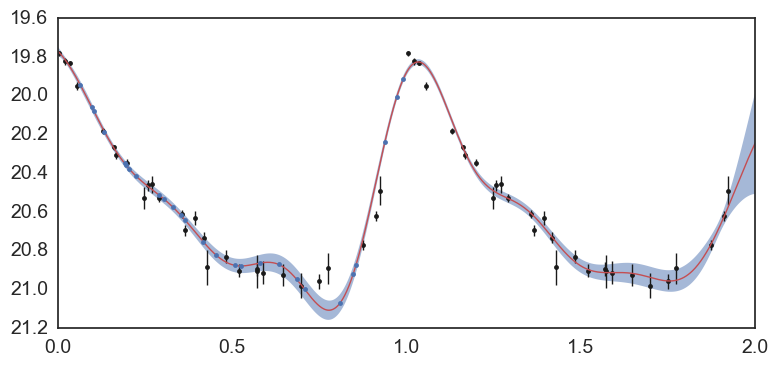

22.2431515922 25

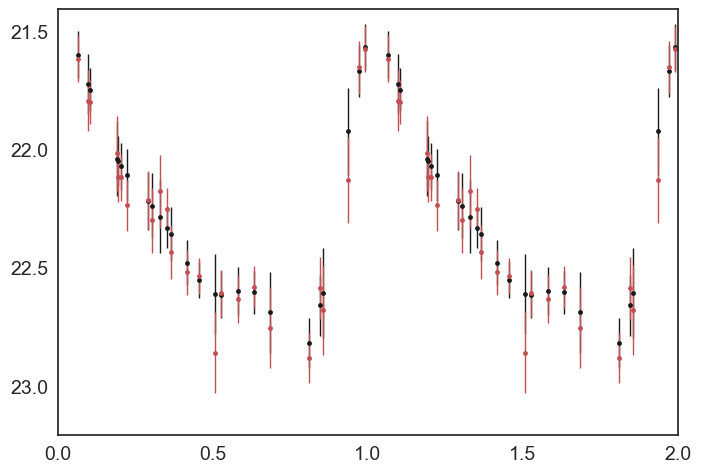

19 [ 0.10329103] 20.425804398 23 27 Blind15A_15_N21_0971_2841
Period: 0.380230 days


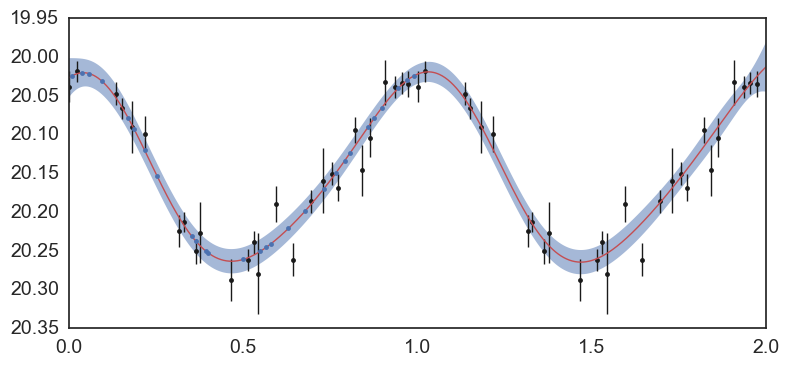

23.3022344301 24

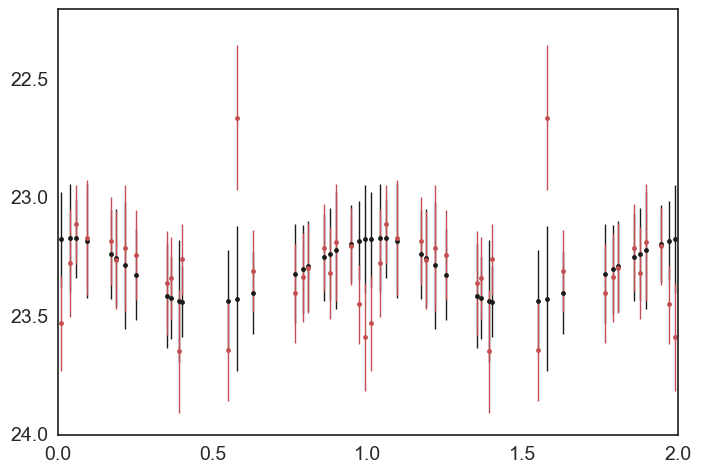

9 [ 0.47121538] 23.8991100797 23 29

KeyboardInterrupt: 

In [38]:
all_lcs, all_per = [], []
count = 0
for item in class_example.iterrows():
    if item[0] == 'Blind15A_22_S27_0428_0159' or \
       item[0] == 'Blind15A_33_S19_1145_0097' or \
        item[0] == 'Blind15A_05_S23_0455_3568' or \
        item[0] == 'Blind15A_19_N4_0938_3573': continue
    count += 1
    if count > 50: break
    T = float(item[1]['PeriodLS'])
    T_W = float(item[1]['PeriodWMCC'])
    T_G = float(item[1]['PeriodGLS'])
    print item[0]
    field, CCD, X, Y = re.findall(
                r'(\w+\d+\w?\_\d\d?)\_(\w\d+?)\_(\d+)\_(\d+)', item[0])[0]
    time, mag, err, time2, mag2, err2 = give_me_lc(field, CCD, X, Y,extract=False)
    filtered_data = sigma_clip(mag, sigma=3, iters=1,
                               cenfunc=np.mean, copy=False)
    time = time[~filtered_data.mask]
    mag = mag[~filtered_data.mask]
    err = err[~filtered_data.mask]
    print 'Period: %f days' % (T)
    n = np.random.choice(range(49))
    hits_time = time_all[n][:,1]
    # predicted magnitude for GP
    if var_class == 'NV':
        mag_obs = GP_fit(time, mag, err, plot=True, x_pred=hits_time)
    else:
        mag_obs = GP_fit_periodic(time, mag, err, T, T_1=T, plot=True, x_pred=hits_time)
        
    # scale to HiTS depth and add empirical uncertainties
    hits_mag, hits_noise_mag, hits_err = HiTS_depth_noise(mag_obs)
    if hits_mag.mean() < 20:
        size = int(len(hits_time)*np.random.uniform(.95,1., size=1))
    elif hits_mag.mean() < 22 and hits_mag.mean() > 20:
        size = int(len(hits_time)*np.random.uniform(.85,1., size=1))
    else:
        size = int(len(hits_time)*np.random.uniform(.75,1., size=1))  
    print hits_mag.mean(), size,
    idx = np.sort(np.random.choice(np.arange(len(hits_time)),
                       size=size, replace=False))
    hits_time = hits_time[idx]
    hits_mag = hits_mag[idx]
    hits_noise_mag = hits_noise_mag[idx]
    hits_err = hits_err[idx]
    
    if var_class == 'NV':
        plt.figure(figsize=(9,4))
        plt.errorbar(hits_time, hits_mag, yerr=hits_err, fmt='k.', ms=7, lw=1,alpha=1)
        plt.errorbar(hits_time, hits_noise_mag, yerr=hits_err, fmt='r.', ms=7, lw=1,alpha=1)
        plt.gca().invert_yaxis()
        plt.show()
    
    else:
        phase = np.mod(hits_time, T) / T
        sort_idx = np.argsort(phase)

        hits_PHASE = phase[sort_idx]
        hits_MAG = hits_mag[sort_idx]
        hits_noise_MAG = hits_noise_mag[sort_idx]
        hits_ERR = hits_err[sort_idx]

        hits_MAG = np.concatenate([hits_MAG,hits_MAG])
        hits_noise_MAG = np.concatenate([hits_noise_MAG,hits_noise_MAG])
        hits_PHASE = np.concatenate([hits_PHASE,hits_PHASE+1])
        hits_ERR = np.concatenate([hits_ERR,hits_ERR])
    
        plt.errorbar(hits_PHASE, hits_MAG, yerr=hits_ERR, fmt='k.', ms=7, lw=1,alpha=1)
        plt.errorbar(hits_PHASE, hits_noise_MAG, yerr=hits_ERR, fmt='r.', ms=7, lw=1,alpha=1)
        plt.gca().invert_yaxis()
        plt.show()
    
    
    for k in range(n_gen):
        if var_class == 'ROTVAR':
            up_lim = 10*T
            if up_lim > 15: up_lim = 15.
            T_1 = np.random.uniform(0.01, up_lim)
        elif var_class == 'RRLYR':
            T_1 = np.random.uniform(.05, 1,1)
        elif var_class == 'RRLYR':
            T_1 = np.random.uniform(0.02, 0.33)
        elif var_class == 'NV':
            T_1 = 'same'
    
        # HiTS sampling function
        #hits_time = time_obs[HiTS_sample_func(time_obs)]
        n = np.random.choice(range(49))
        hits_time = time_all[n][:,1]
        # predicted magnitude for 
        if var_class == 'NV':
            mag_obs = GP_fit(time, mag, err, plot=False, x_pred=hits_time)
        else:
            mag_obs = GP_fit_periodic(time, mag, err, T, T_1=T_1, plot=False, x_pred=hits_time)
        # scale to HiTS depth and add empirical uncertainties
        hits_mag, hits_noise_mag, hits_err = HiTS_depth_noise(mag_obs)
        if hits_mag.mean() < 20:
            size = int(len(hits_time)*np.random.uniform(.95,1., size=1))
        elif hits_mag.mean() < 22 and hits_mag.mean() > 20:
            size = int(len(hits_time)*np.random.uniform(.85,1., size=1))
        else:
            size = int(len(hits_time)*np.random.uniform(.75,1., size=1))  
        print '\r',k, T_1, hits_mag.mean(), size,len(hits_time),
        idx = np.sort(np.random.choice(np.arange(len(hits_time)),
                       size=size, replace=False))
        hits_time = hits_time[idx]
        hits_mag = hits_mag[idx]
        hits_noise_mag = hits_noise_mag[idx]
        hits_err = hits_err[idx]
    
        df = pd.DataFrame(np.array([hits_time, hits_noise_mag, hits_err]).T,
                          columns=['MJD','MAG_KRON','MAGERR_KRON'])
        if False:
            path = '%s/synt_lcs/%s_%i_%.6f.csv' % (mainpath, var_class,k,T_1)
            df.to_csv(path)
        all_lcs.append(df)
        all_per.append(T_1)

In [33]:
p = Pool(processes=n_process)
frames_3 = p.map(get_features, zip(all_lcs, range(len(all_lcs))))

 LC 600: rotvar_3.087862...
 LC 642: rotvar_13.354325...
 LC 621: rotvar_2.443903...
 LC 601: rotvar_13.018276...
 LC 643: rotvar_1.114857...
 LC 622: rotvar_2.654120...
 LC 644: rotvar_7.050615...
 LC 602: rotvar_5.265840...
 LC 623: rotvar_9.595043...
 LC 603: rotvar_8.943505...
 LC 645: rotvar_11.339390...
 LC 604: rotvar_1.489030...
 LC 646: rotvar_8.758074...
 LC 624: rotvar_14.289505...
 LC 605: rotvar_6.647483...
 LC 647: rotvar_2.576991...
 LC 625: rotvar_9.572818...
 LC 606: rotvar_14.720054...
 LC 648: rotvar_11.667358...
 LC 626: rotvar_14.337696...
 LC 649: rotvar_13.904270...
 LC 607: rotvar_2.354283...
 LC 627: rotvar_6.395694...
 LC 650: rotvar_1.888817...
 LC 608: rotvar_1.753898...
 LC 628: rotvar_12.341606...
 LC 651: rotvar_3.468155...
 LC 609: rotvar_2.232723...
 LC 629: rotvar_12.511192...
 LC 652: rotvar_0.146220...
 LC 610: rotvar_12.452870...
 LC 630: rotvar_1.381431...
 LC 653: rotvar_3.580682...
 LC 611: rotvar_3.890880...
 LC 631: rotvar_12.949749...
 LC 654:

In [40]:
fats_feat = pd.concat(fr, axis = 0)
fats_feat = fats_feat[np.sort(fats_feat.columns.values)]
fats_feat['Var_Type'] = var_class
print fats_feat.shape

(50, 65)


,Real_Period,Var_Type
rotvar_0.626138,0.626138,ROTVAR
rotvar_0.798550,0.798550,ROTVAR
rotvar_0.043483,0.043483,ROTVAR
rotvar_1.006410,1.006410,ROTVAR
rotvar_0.250184,0.250184,ROTVAR


In [42]:
fats_feat.to_csv('%s/tables/Syntectic_%s_features_noise.csv' % (mainpath, var_class))

In [52]:
zip(all_lcs, range(len(all_lcs)), ['hola']*len(all_lcs))[:2]

[(             MJD   MAG_KRON  MAGERR_KRON
  0   57070.112565  23.384548     0.242238
  1   57070.197723  23.269545     0.214942
  2   57070.266360  24.056908     0.261017
  3   57071.041361  23.633526     0.240569
  4   57071.109123  23.822429     0.217659
  5   57071.244941  24.635153     0.254102
  6   57072.105773  24.280607     0.220354
  7   57072.174691  24.533512     0.232673
  8   57072.243256  24.154554     0.233841
  9   57072.312548  24.629778     0.227015
  10  57073.035524  23.807871     0.217893
  11  57073.103226  24.124540     0.218161
  12  57074.297541  23.437559     0.234384
  13  57075.030662  23.491365     0.248314
  14  57075.098267  23.789536     0.317956
  15  57075.165577  23.987036     0.221434
  16  57075.234427  23.271076     0.260162
  17  57075.303052  23.396164     0.235848
  18  57077.083040  23.402408     0.219392
  19  57077.143659  23.789470     0.234438
  20  57080.074411  23.548817     0.268633
  21  57080.141794  24.156054     0.243800, 0, 'hola')